# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


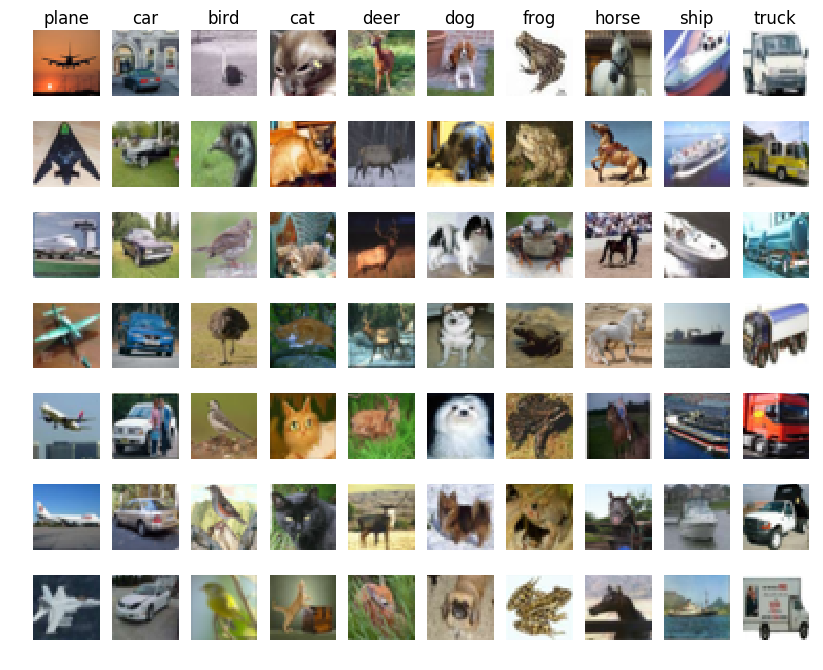

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


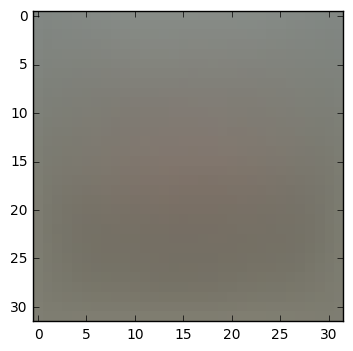

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.720505


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 30.578691 analytic: 30.578691, relative error: 1.893876e-11


numerical: 1.825231 analytic: 1.825231, relative error: 3.699313e-11


numerical: 3.416587 analytic: 3.416587, relative error: 6.480990e-11


numerical: 15.786319 analytic: 15.786319, relative error: 2.636913e-12


numerical: -17.224370 analytic: -17.224370, relative error: 2.350900e-11


numerical: -2.425911 analytic: -2.425911, relative error: 1.465149e-10


numerical: -18.411867 analytic: -18.411867, relative error: 1.622650e-11


numerical: 23.347968 analytic: 23.347968, relative error: 1.286270e-11


numerical: 14.743523 analytic: 14.743523, relative error: 1.767619e-12


numerical: -6.510983 analytic: -6.510983, relative error: 4.098332e-11


numerical: -6.955810 analytic: -6.955810, relative error: 8.086526e-12


numerical: 13.760750 analytic: 13.760750, relative error: 8.717035e-12


numerical: -14.721295 analytic: -14.721295, relative error: 5.609210e-12


numerical: 42.109737 analytic: 42.109737, relative error: 4.900599e-12


numerical: 28.139389 analytic: 28.139389, relative error: 1.358305e-12


numerical: 3.844732 analytic: 3.844732, relative error: 4.776446e-11


numerical: -15.787810 analytic: -15.787810, relative error: 2.957409e-11


numerical: 18.318964 analytic: 18.318964, relative error: 1.322452e-12


numerical: 8.947373 analytic: 8.947373, relative error: 5.948473e-12


numerical: -12.297696 analytic: -12.297696, relative error: 3.790213e-11


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.720505e+00 computed in 0.218435s
Vectorized loss: 9.720505e+00 computed in 0.019677s
difference: 0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.237284s
Vectorized loss and gradient: computed in 0.015868s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 783.135607


iteration 100 / 1500: loss 284.721886


iteration 200 / 1500: loss 107.374635


iteration 300 / 1500: loss 42.468147


iteration 400 / 1500: loss 18.691836


iteration 500 / 1500: loss 10.161892


iteration 600 / 1500: loss 7.125308


iteration 700 / 1500: loss 5.642675


iteration 800 / 1500: loss 5.816690


iteration 900 / 1500: loss 5.160331


iteration 1000 / 1500: loss 4.958259


iteration 1100 / 1500: loss 5.813983


iteration 1200 / 1500: loss 5.150308


iteration 1300 / 1500: loss 5.891728


iteration 1400 / 1500: loss 5.254201


That took 9.268008s


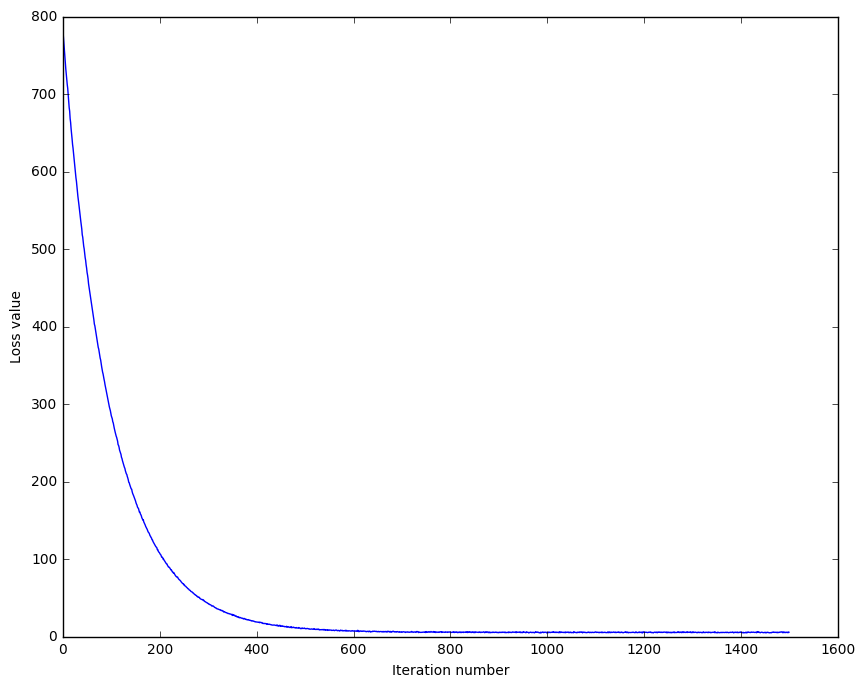

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.371204
validation accuracy: 0.378000


In [38]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7]
regularization_strengths = [1e3, 3e3, 5e3, 7e3, 1e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm_temp = LinearSVM()
        svm_temp.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=5000, verbose=True)
        train_predict_temp = svm_temp.predict(X_train)
        val_predict_temp = svm_temp.predict(X_val)
        train_accuracy_temp = np.mean(y_train == train_predict_temp)
        val_accuracy_temp = np.mean(y_val == val_predict_temp)
        results[(lr, reg)] = (train_accuracy_temp, val_accuracy_temp)
        if best_val < val_accuracy_temp:
            best_val = val_accuracy_temp
            best_svm = svm_temp
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 5000: loss 40.152490


iteration 100 / 5000: loss 25.890206


iteration 200 / 5000: loss 23.481759


iteration 300 / 5000: loss 22.926810


iteration 400 / 5000: loss 22.242309


iteration 500 / 5000: loss 20.561419


iteration 600 / 5000: loss 20.095621


iteration 700 / 5000: loss 19.254887


iteration 800 / 5000: loss 18.992687


iteration 900 / 5000: loss 19.860628


iteration 1000 / 5000: loss 17.402596


iteration 1100 / 5000: loss 17.941546


iteration 1200 / 5000: loss 18.196646


iteration 1300 / 5000: loss 17.230590


iteration 1400 / 5000: loss 17.640080


iteration 1500 / 5000: loss 17.030794


iteration 1600 / 5000: loss 17.352057


iteration 1700 / 5000: loss 16.444848


iteration 1800 / 5000: loss 15.893239


iteration 1900 / 5000: loss 16.172846


iteration 2000 / 5000: loss 15.051410


iteration 2100 / 5000: loss 14.228189


iteration 2200 / 5000: loss 13.897225


iteration 2300 / 5000: loss 14.047427


iteration 2400 / 5000: loss 14.671451


iteration 2500 / 5000: loss 14.330793


iteration 2600 / 5000: loss 13.957189


iteration 2700 / 5000: loss 13.559939


iteration 2800 / 5000: loss 12.747173


iteration 2900 / 5000: loss 13.110808


iteration 3000 / 5000: loss 12.701766


iteration 3100 / 5000: loss 12.372772


iteration 3200 / 5000: loss 12.355861


iteration 3300 / 5000: loss 11.811861


iteration 3400 / 5000: loss 12.081442


iteration 3500 / 5000: loss 12.104969


iteration 3600 / 5000: loss 11.093107


iteration 3700 / 5000: loss 11.239756


iteration 3800 / 5000: loss 10.991091


iteration 3900 / 5000: loss 11.012249


iteration 4000 / 5000: loss 10.681784


iteration 4100 / 5000: loss 11.321876


iteration 4200 / 5000: loss 10.540790


iteration 4300 / 5000: loss 10.511592


iteration 4400 / 5000: loss 10.473155


iteration 4500 / 5000: loss 9.543430


iteration 4600 / 5000: loss 10.277532


iteration 4700 / 5000: loss 9.939821


iteration 4800 / 5000: loss 10.091920


iteration 4900 / 5000: loss 9.859476


iteration 0 / 5000: loss 72.167479


iteration 100 / 5000: loss 55.358009


iteration 200 / 5000: loss 50.140337


iteration 300 / 5000: loss 47.633147


iteration 400 / 5000: loss 44.374318


iteration 500 / 5000: loss 40.729287


iteration 600 / 5000: loss 38.504152


iteration 700 / 5000: loss 36.118699


iteration 800 / 5000: loss 36.280533


iteration 900 / 5000: loss 32.011216


iteration 1000 / 5000: loss 30.710223


iteration 1100 / 5000: loss 28.717678


iteration 1200 / 5000: loss 27.562288


iteration 1300 / 5000: loss 26.498084


iteration 1400 / 5000: loss 24.744129


iteration 1500 / 5000: loss 23.201074


iteration 1600 / 5000: loss 22.344009


iteration 1700 / 5000: loss 21.314134


iteration 1800 / 5000: loss 19.837275


iteration 1900 / 5000: loss 19.949660


iteration 2000 / 5000: loss 17.661533


iteration 2100 / 5000: loss 17.974627


iteration 2200 / 5000: loss 16.145269


iteration 2300 / 5000: loss 15.749196


iteration 2400 / 5000: loss 15.062711


iteration 2500 / 5000: loss 14.067742


iteration 2600 / 5000: loss 13.396904


iteration 2700 / 5000: loss 13.679025


iteration 2800 / 5000: loss 12.444713


iteration 2900 / 5000: loss 11.981126


iteration 3000 / 5000: loss 11.768244


iteration 3100 / 5000: loss 11.109353


iteration 3200 / 5000: loss 10.431586


iteration 3300 / 5000: loss 10.163063


iteration 3400 / 5000: loss 10.257882


iteration 3500 / 5000: loss 9.759049


iteration 3600 / 5000: loss 10.068901


iteration 3700 / 5000: loss 9.067650


iteration 3800 / 5000: loss 8.696488


iteration 3900 / 5000: loss 8.377384


iteration 4000 / 5000: loss 8.363231


iteration 4100 / 5000: loss 7.979051


iteration 4200 / 5000: loss 7.884353


iteration 4300 / 5000: loss 7.244448


iteration 4400 / 5000: loss 7.383952


iteration 4500 / 5000: loss 7.121760


iteration 4600 / 5000: loss 7.487211


iteration 4700 / 5000: loss 6.511604


iteration 4800 / 5000: loss 7.141218


iteration 4900 / 5000: loss 7.197654


iteration 0 / 5000: loss 97.853529


iteration 100 / 5000: loss 79.970819


iteration 200 / 5000: loss 72.357056


iteration 300 / 5000: loss 64.068744


iteration 400 / 5000: loss 58.437028


iteration 500 / 5000: loss 52.633024


iteration 600 / 5000: loss 48.434222


iteration 700 / 5000: loss 44.231102


iteration 800 / 5000: loss 38.331410


iteration 900 / 5000: loss 36.381379


iteration 1000 / 5000: loss 32.807249


iteration 1100 / 5000: loss 30.100131


iteration 1200 / 5000: loss 27.238479


iteration 1300 / 5000: loss 24.601418


iteration 1400 / 5000: loss 23.203286


iteration 1500 / 5000: loss 20.846183


iteration 1600 / 5000: loss 20.070212


iteration 1700 / 5000: loss 17.906462


iteration 1800 / 5000: loss 16.773451


iteration 1900 / 5000: loss 15.180997


iteration 2000 / 5000: loss 14.460197


iteration 2100 / 5000: loss 13.426976


iteration 2200 / 5000: loss 12.263748


iteration 2300 / 5000: loss 11.835081


iteration 2400 / 5000: loss 10.803203


iteration 2500 / 5000: loss 10.557865


iteration 2600 / 5000: loss 10.019582


iteration 2700 / 5000: loss 9.359745


iteration 2800 / 5000: loss 9.530969


iteration 2900 / 5000: loss 8.905065


iteration 3000 / 5000: loss 7.923528


iteration 3100 / 5000: loss 7.520746


iteration 3200 / 5000: loss 6.612197


iteration 3300 / 5000: loss 6.751634


iteration 3400 / 5000: loss 6.634971


iteration 3500 / 5000: loss 6.656737


iteration 3600 / 5000: loss 6.227646


iteration 3700 / 5000: loss 6.126737


iteration 3800 / 5000: loss 6.159173


iteration 3900 / 5000: loss 6.321933


iteration 4000 / 5000: loss 5.309092


iteration 4100 / 5000: loss 5.985677


iteration 4200 / 5000: loss 5.538063


iteration 4300 / 5000: loss 5.524607


iteration 4400 / 5000: loss 5.564179


iteration 4500 / 5000: loss 5.661154


iteration 4600 / 5000: loss 5.219686


iteration 4700 / 5000: loss 5.069024


iteration 4800 / 5000: loss 5.076072


iteration 4900 / 5000: loss 4.891542


iteration 0 / 5000: loss 132.429646


iteration 100 / 5000: loss 103.973183


iteration 200 / 5000: loss 89.827315


iteration 300 / 5000: loss 78.806342


iteration 400 / 5000: loss 67.680099


iteration 500 / 5000: loss 59.290753


iteration 600 / 5000: loss 50.893539


iteration 700 / 5000: loss 44.927540


iteration 800 / 5000: loss 39.272859


iteration 900 / 5000: loss 35.468385


iteration 1000 / 5000: loss 31.404211


iteration 1100 / 5000: loss 27.293331


iteration 1200 / 5000: loss 24.170100


iteration 1300 / 5000: loss 21.859634


iteration 1400 / 5000: loss 19.607475


iteration 1500 / 5000: loss 17.283433


iteration 1600 / 5000: loss 16.063185


iteration 1700 / 5000: loss 14.320765


iteration 1800 / 5000: loss 13.100504


iteration 1900 / 5000: loss 11.881698


iteration 2000 / 5000: loss 10.988454


iteration 2100 / 5000: loss 9.539529


iteration 2200 / 5000: loss 8.802083


iteration 2300 / 5000: loss 8.680262


iteration 2400 / 5000: loss 8.390363


iteration 2500 / 5000: loss 7.571768


iteration 2600 / 5000: loss 7.263541


iteration 2700 / 5000: loss 6.798874


iteration 2800 / 5000: loss 6.519377


iteration 2900 / 5000: loss 6.283824


iteration 3000 / 5000: loss 6.319564


iteration 3100 / 5000: loss 6.280828


iteration 3200 / 5000: loss 5.911973


iteration 3300 / 5000: loss 6.880411


iteration 3400 / 5000: loss 5.627786


iteration 3500 / 5000: loss 5.544588


iteration 3600 / 5000: loss 6.106443


iteration 3700 / 5000: loss 5.784380


iteration 3800 / 5000: loss 4.614223


iteration 3900 / 5000: loss 4.734402


iteration 4000 / 5000: loss 5.025380


iteration 4100 / 5000: loss 4.380162


iteration 4200 / 5000: loss 4.365651


iteration 4300 / 5000: loss 4.667841


iteration 4400 / 5000: loss 4.918797


iteration 4500 / 5000: loss 5.023645


iteration 4600 / 5000: loss 4.844862


iteration 4700 / 5000: loss 5.367377


iteration 4800 / 5000: loss 5.129281


iteration 4900 / 5000: loss 5.023113


iteration 0 / 5000: loss 178.889488


iteration 100 / 5000: loss 135.578941


iteration 200 / 5000: loss 111.207606


iteration 300 / 5000: loss 89.705748


iteration 400 / 5000: loss 74.920429


iteration 500 / 5000: loss 61.330739


iteration 600 / 5000: loss 50.984016


iteration 700 / 5000: loss 42.927036


iteration 800 / 5000: loss 35.116729


iteration 900 / 5000: loss 29.257724


iteration 1000 / 5000: loss 25.256907


iteration 1100 / 5000: loss 21.906965


iteration 1200 / 5000: loss 17.768443


iteration 1300 / 5000: loss 15.779958


iteration 1400 / 5000: loss 13.646087


iteration 1500 / 5000: loss 12.191307


iteration 1600 / 5000: loss 10.679051


iteration 1700 / 5000: loss 9.483377


iteration 1800 / 5000: loss 8.475902


iteration 1900 / 5000: loss 8.529109


iteration 2000 / 5000: loss 7.346755


iteration 2100 / 5000: loss 6.793983


iteration 2200 / 5000: loss 6.417223


iteration 2300 / 5000: loss 5.952240


iteration 2400 / 5000: loss 5.600962


iteration 2500 / 5000: loss 5.650571


iteration 2600 / 5000: loss 5.813408


iteration 2700 / 5000: loss 5.445542


iteration 2800 / 5000: loss 5.397698


iteration 2900 / 5000: loss 5.435338


iteration 3000 / 5000: loss 4.955844


iteration 3100 / 5000: loss 4.820544


iteration 3200 / 5000: loss 4.909623


iteration 3300 / 5000: loss 5.052351


iteration 3400 / 5000: loss 5.100511


iteration 3500 / 5000: loss 4.999259


iteration 3600 / 5000: loss 4.723795


iteration 3700 / 5000: loss 5.626630


iteration 3800 / 5000: loss 5.167126


iteration 3900 / 5000: loss 4.527302


iteration 4000 / 5000: loss 4.995275


iteration 4100 / 5000: loss 4.648747


iteration 4200 / 5000: loss 5.264249


iteration 4300 / 5000: loss 5.031705


iteration 4400 / 5000: loss 4.515338


iteration 4500 / 5000: loss 4.696973


iteration 4600 / 5000: loss 5.180113


iteration 4700 / 5000: loss 4.457963


iteration 4800 / 5000: loss 4.578780


iteration 4900 / 5000: loss 4.694962


lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.373204 val accuracy: 0.374000
lr 1.000000e-07 reg 3.000000e+03 train accuracy: 0.401980 val accuracy: 0.398000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.402327 val accuracy: 0.401000
lr 1.000000e-07 reg 7.000000e+03 train accuracy: 0.400633 val accuracy: 0.398000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.395857 val accuracy: 0.394000
best validation accuracy achieved during cross-validation: 0.401000


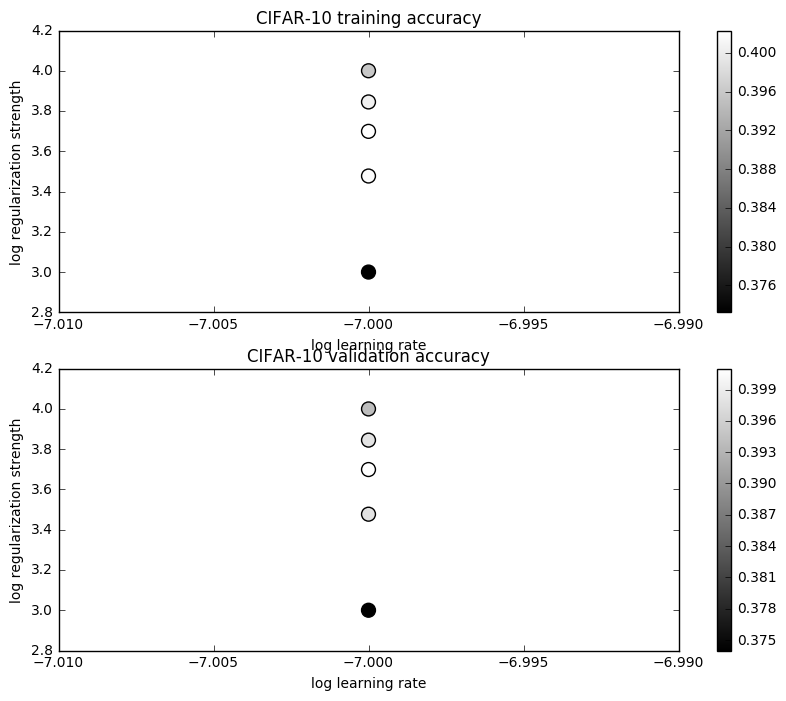

In [39]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [40]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.380000


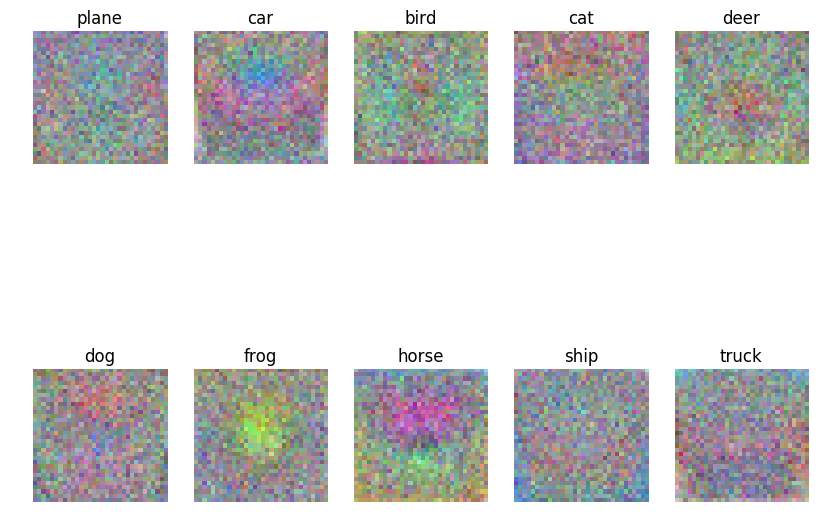

In [41]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *The visualized weights look like mixture of images of a class. Because the weights form a template, which stacks characteristics of images of the corresponding class *